# Evaluating Mental Health Trends and Predictors among Students

## Phase 2: Predictive Modelling

##### Group Name: 139
##### Group Members: Sothearaot Tat (s4058460) & Phuong Pham (s4078692)

- [1. Introduction](#1.-Introduction)
    - [1.1 Phase 1 Summary](#1.1-Phase-1-Summary)
    - [1.2 Report Overview](#1.2-Report-Overview)
    - [1.3 Overview Methodology](#1.3-Overview-Methodology)
- [2. Predictive Modelling](#2.-Predictive-Modelling)
    - [2.1 Feature Selection](#2.1-Feature-Selection)
    - [2.2 Model Fitting & Tunning](#2.2-Model-Fitting-&-Tunning)
    - [2.3 Neural Networks Model Fitting & Tunning](#2.3-Neural-Networks-Model-Fitting-&-Tunning)
    - [2.4 Model Comparison](#2.4-Model-Comparison)
- [3. Critique & Limitation](#3.-Critique-&-Limitation)
- [4. Summary & Conclusion](#4.-Summary-&-Conclusion)
    - [4.1 Project Summary](#4.1-Project-Summary)
    - [4.2 Summary of Findings](#4.2-Summary-of-Findings)
    - [4.3 Conclusion](#4.3-Conclusion)
- [5. Reference](#Reference)

In [1]:
# Import packages
## Disable warning messages
import warnings
import joblib
import os
warnings.filterwarnings("ignore")

#Packages to import data from OpenML
import openml
from openml import datasets, tasks, runs, flows, config, study
from openml.datasets import edit_dataset, fork_dataset, get_dataset
from openml.tasks import TaskType
import arff

## Packages for data preprocessing
import numpy as np
import pandas as pd
import io
import requests

#ML algorithm packages
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.optimizers import SGD, Adam, schedules
from keras.callbacks import EarlyStopping
from keras.metrics import AUC

import tensorflow as tf
tf.config.run_functions_eagerly(True)

pd.set_option('display.max_columns', None) 

## Packages for data visualizing
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate

## 1. Introduction

### 1.1 Phase 1 Summary

During the first Phase of the project, essential data cleaning,preprocessing, and exploratory analysis were conducted to buid the groundwork for this Phase 2's predictive modeling optimization. The primary objective was to prepare the dataset for subsequent predictive modeling by ensuring its integrity, intepreability and analytical suitability.

The cleaning process involved excluding irrelevant or redundant columns, addressing missing values, and guaranteeing to maintain the appropriateness of all variables' format. The irrelevant unique identifier "id", student's city of origin "city", or any redundant features have been removed as only those variables that may have the probability to directly influence the degree of depression are kept to fit the machine learning models. Missing values were filtered out before getting dropped since it accounts for less than 1% of the observations and will not likely significantly influence the outcome. After ensuring the dataset was clean without existing duplicates, NA, outliers, inappropriate data type and values, the preprocessing step sampled approximately one-third of the observations to achive randomness and diversity, which improves the predictive performance in terms of speed and feasibility, especially for complicated models.

Exploratory data analysis was carried out through summary statictics and visualizations between multiple variables, assisting in not only investigating the concise overview of dataset's characteristics, but also identifying the potentially influential predictors and highlighted patterns relevant to mental health outcomes. In specification, the results observed stated that demographic factors like age and genders, alongside with student's stresses and their academic performance metric may serve as crucial foundation for Phase 2, where predictive models will be developed. Phase 1 generally ensure the readiness of the dataset to gain insight into the mental health condition, which optimize the decisions regarding feature selection and model types in this next phase of the analysis.

The below is the final dataset after cleaning and preprocessing, which has been extracted to a csv file in order to be fitted into predictive models.

In [22]:
#reading data
data = pd.read_csv('Phase2_Group139.csv')
depress2 = pd.DataFrame(data, columns=data.columns)
depress2.head()

,gender,age,profession,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,sleep_duration,dietary_habits,degree,suicidal_thoughts,work_study_hrs,financial_stress,family_mental_hist,depression
0,Male,29,Student,3,0,9.72,1,0,Less than 5 hours,Moderate,BA,No,11,2,Yes,1
1,Male,20,Student,5,0,9.96,1,0,Less than 5 hours,Unhealthy,year12,Yes,12,3,Yes,1
2,Female,20,Student,1,0,7.24,5,0,Less than 5 hours,Healthy,year12,No,11,5,No,0
3,Male,18,Student,4,0,6.37,2,0,Less than 5 hours,Moderate,year12,Yes,10,3,Yes,1
4,Female,19,Student,1,0,9.11,3,0,More than 8 hours,Healthy,year12,No,6,2,Yes,0


### 1.2 Report Overview

During this Phase 2 report, the analysis focuses on the development and evaluation of predictive models based on the preparation in Phase 1. Building on a cleaned and organized dataset, the study aims to identify suitable algorithms for classification tasks and assess the corresponding features in predicting depression levels. A variety of supervised learning models will be evaluated, including 4 classificatiions: Logistic Regression, K-Nearest Neighbours, Decision Trees, and Naive Bayes, with an emphasis on understanding their accuracy, precision, recall, and overall robustness.

The report initially define the target variable and feature selected from the earlier phase to then proceed with the training and testing samples of multiple approaches, supported by cross-validation techniques for each one. Multiple key evaluiation metrics are applied for further intepretation in modeling comparison. This phase looks forward to find the most accurate model, besides understanding the predictability of individual features, assess model interpretability, and achieve practical applicability in real-world situations. The ultimate goal is to use the above findings in contributing to forming actionable insight and guiding decisions to deal with depressed students.

### 1.3. Overview of Methodology

Having the target feature as a binary type, the consideration shifts towards the employment of the following four supervised learning algorithm to fit the predictive models:

- Logistic Regression (LR)
- K-Nearest Neighbors (KNN)
- Decision Tree (DT)
- Random Forest (RF)

The methodology focuses on transforming the cleaned dataset extracted from the first Phase. All four models will be trained using a consistent Pipeline that includes preprocessing steps such as median imputation for numerical features, one-hot encoding for categorical descriptive features to binary data, and standardize scalling. These steps help ensure compatibility accross different model types, particularly those sensitive to scale.

After the project's Phase 1, a random sample of 10 thousand observations was filtered from the full dataset, it will be then splitted into training and testing sets using train_test_split function from scikit-learn library, with a 50-50 ratio: 50% of the data will be allocated for training while the testing accounts for the rest half. This stratified split is critical for maintaining class balance, especially in binary classification tasks, and help avoid biased model performance to ensure reproductibility across different runs. Each model undergoes a hyperparameter tuning using GridSearchCV with 5-fold cross validation. 

The ROC-AUC score is used as the default scoring metric, given its effectiveness in reflecting generalization and threshold-independent performance. However, recall is emphasized in the performance interpretation, as identifying true cases of depression is crucial in healthcare contexts. Although false positives (mislabeling non-depressed individuals) may be tolerable in educational settings, false negatives (failing to detect depression) can be harmful from a healthcare standpoint. Accordingly, confusion matrix metrics—including accuracy, precision, recall, and F1-score—are also reported to provide a comprehensive view of each model's performance.

## 2. Predictive Modelling

### 2.1 Feature Selection (FS)

In phase 1, "City" was dropped from the group of descriptive features due to its being too granulated, therefore expected to provide information that would prevent rather than faciliate generalisation. In order words, this feature was dropped to prevent overfitting. As a preliminary effort to further select features for the training of the data, a correlation matrix is created for all numerical features of the data (see: *figure1*). The correlation matrix shows promisingly weak correlation between almost all of the descriptive numerical features, implying colinearity is not an issue. However, the correlation between "work_pressure" and "job_satisfaction" is highly positive. This may be true as more difficult jobs can be more gratifying, but it doubtful that pressure would lead to satisfaction. Upon examining the data further, it was found that among the 10,000 samples taken from the original dataset, only 2 observations have non-zero values for both academic pressure and job satisfaction. Both descriptive features are most likely insgnificant to any models as it can be effectively disregarded due to its low variability. As such, they are removed from the pool of features. 

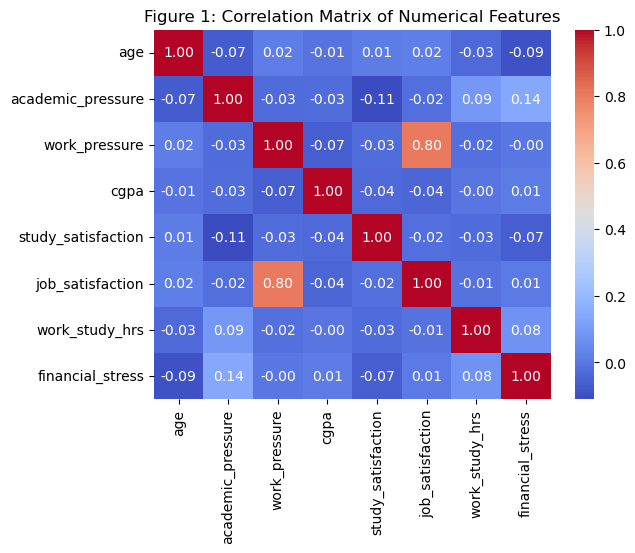

In [31]:
numeric_data = depress2.drop("depression", axis=1).select_dtypes(exclude='object')
corr = numeric_data.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Figure 1: Correlation Matrix of Numerical Features")
plt.show()

*Figure 2* shows the scatterplots of each categorical features against the target feature, depression. For most of the features, at least one category an be seen vary in number between the depressed and non-depressed groups. For instance, there are more number of depressed males (indicated by 1) than females. Another example is the difference in the number of depression individuals between those who have suicidal thoughts and those who do not. However, there appears to be minimal variability in profession. Most of the sampled data are students (indicated by 6 in profession). Due to this, it is unlikely that this feature will provide important information to any models. Therefore, this feature is also removed from the selection of features.

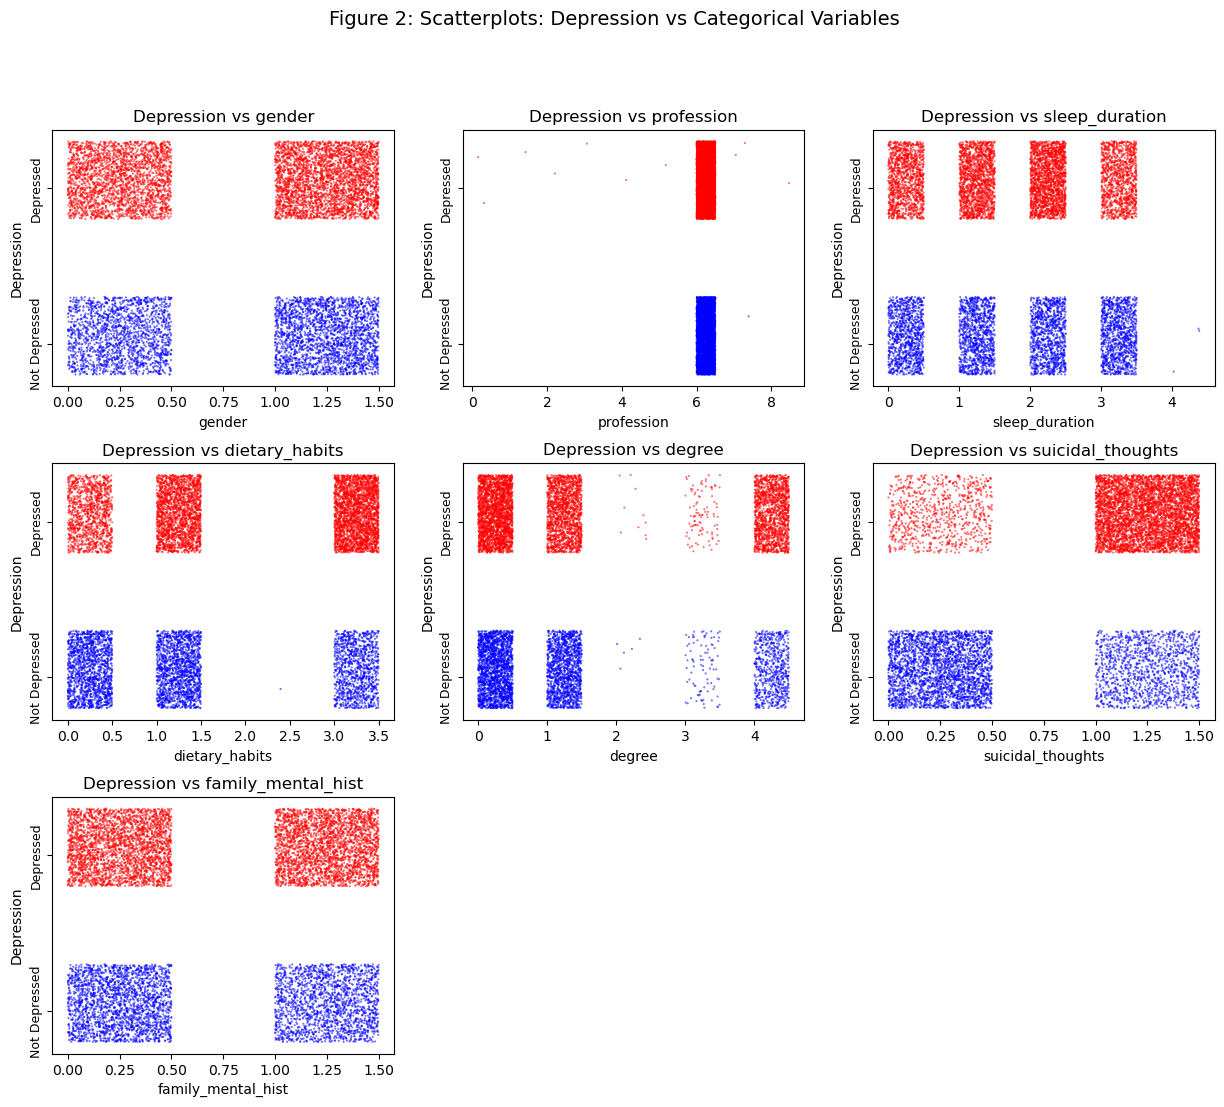

In [34]:
import numpy as np
import matplotlib.pyplot as plt

#plotting depression by gender
    #ensuring columns are categorical
plot2_df = depress2.copy().select_dtypes(include = "object")
plot2_df["depression"] = depress2["depression"]

for col in plot2_df.columns:
    plot2_df[col] = plot2_df[col].astype('category') 

    #assign numerical values to categorical columns
for col in plot2_df.columns:
    plot2_df[col] = plot2_df[col].cat.codes
    
       #add random noise to make the dots jitter
xnoise, ynoise = np.random.random(len(plot2_df))/2, np.random.random(len(plot2_df))/2 # The noise is in the range 0 to 0.5

# Plot the scatterplot
fig, plot = plt.subplots(3, 3, figsize=(15, 12))
plot = plot.flatten()

for i, col in enumerate(plot2_df.columns):
    g = plot[i]
    
    # Get numeric codes for x to jitter on x-axis
    x = plot2_df[col]
    y = plot2_df['depression']

    x_jitter = x + xnoise
    y_jitter = y + ynoise

     # Plot jittered scatter plot, color by depress
    g.scatter(x_jitter, y_jitter, c=y, cmap='bwr', alpha=0.6, s=0.25)
    
    
    g.set_title(f"Depression vs {col}")
    
    g.set_ylabel('Depression')
    g.set_xlabel(col)
    g.set_yticks([0.2, 1.2])
    g.set_yticklabels(['Not Depressed', 'Depressed'],fontsize = 9,rotation=90, va ='center')

fig.delaxes(plot[-1])
fig.delaxes(plot[-2])

fig.suptitle("Figure 2: Scatterplots: Depression vs Categorical Variables", fontsize=14)
plt.subplots_adjust(hspace = 0.3)

In [35]:
depress2 = depress2.drop(columns = ["work_pressure", "job_satisfaction", "profession"])
depress2.columns

Index(['gender', 'age', 'academic_pressure', 'cgpa', 'study_satisfaction',
       'sleep_duration', 'dietary_habits', 'degree', 'suicidal_thoughts',
       'work_study_hrs', 'financial_stress', 'family_mental_hist',
       'depression'],
      dtype='object')

Finally, the ANOVA F-statistic is computed between each feature and the target value. Categorical features are converted into numeric for the computation using dummy variables such that the variable 'gender', for example, which has the values 'male' and 'female', turns into their numerical representation, 1 and 0. All tests between each categorical feature and depression resulted in p-values below 0.05. This provides statistically significant evidence that the target value differ across the classes of each of the features. As such, All 12 remaning features are kept for the trainings and testings of the models.

In [37]:
from sklearn.feature_selection import f_classif
D_features = depress2[[col for col in depress2.columns if col != "depression"]]

for col in D_features.columns:
    if D_features[col].dtype == 'O':
        D_features[col] = D_features[col].astype('category').cat.codes

T_feature = depress2["depression"]

F_val, P_val = f_classif(D_features, T_feature)

f_test_results = pd.DataFrame({
    'Feature': D_features.columns,
    'F_value': F_val,
    'p_value': P_val
})

print(f_test_results.sort_values(by = "p_value"))


               Feature      F_value        p_value
2    academic_pressure  2955.116218   0.000000e+00
8    suicidal_thoughts  4327.777154   0.000000e+00
10    financial_stress  1507.902808  2.323393e-307
1                  age   534.545938  2.950602e-115
9       work_study_hrs   498.944655  6.837336e-108
6       dietary_habits   458.107556   2.066049e-99
4   study_satisfaction   268.506867   1.429769e-59
7               degree   136.613412   2.342223e-31
11  family_mental_hist    28.320958   1.050017e-07
3                 cgpa     6.862612   8.815077e-03
5       sleep_duration     0.946714   3.305807e-01
0               gender     0.350289   5.539629e-01


#### Spliting Training and Test sets

Firstly, the train_test_split is performed to split the data into training and testing sets. A 50/50 split was chosen to allocate equal proportions for model training and evaluation. The stratify parameter was set to the target variable "depression", making sure both training and testing samples preserve the original class distribution.

In [43]:
from sklearn.model_selection import train_test_split
descriptive_cols = [c for c in depress2.columns if c not in ["depression"]]

D_train, D_test, t_train, t_test = train_test_split(depress2[descriptive_cols], 
                                                    depress2["depression"], 
                                                    test_size=0.5,
                                                    stratify = depress2["depression"],
                                                    random_state=139)

print(D_train.shape)
print(D_test.shape)
print(t_train.shape)
print(t_test.shape)

(5000, 12)
(5000, 12)
(5000,)
(5000,)


### 2.2 Model Fitting and Tuning

Before fitting the models, a pipeline is initiated to store all further preprocessing and transforming steps that the data will undertake before model fitting. First, the descriptive features are divided into 3 categories, binary, categorical and numerical. The binary features are one-hot-encoded using dummy variables with one of the two resulting columns removed as it contains the same information. The categorical features are also one-hot-encoded. However, in this case, all resulting columns are kepts. An imputer using median is passed through the pipeline for the numerical variables. This step is unnecessary in this instance as there are no missing values within the data. However, for general applicability, this steps is kept in the pipeline. All numerical variables are scaled using `StandardScaler()` which standardises the data such that the mean and standard deviation become 0 and 1, repsectively. The default scoring metric used for all models is the AUC score, which is the area under the curve of RUC score. High AUC score means that the model predicts higher score for a randomly chosen postive case than to negative ones. The AUC score is chosen as it considers all possible treshold as opposed to one treshold, such as in the case of recall. It also performs well under class imbalance. It should be noted, however, that in this study, recall should be prioritised as the cost of failing to identify a depressed individual is higher than wrongly flagging a non-depressed individual as depressed. In addition to AUC and recall, other metrics such as acurracy, precision and the F1-score which can be calculated from the confusion matrix will also calculated. Cross-validation is also implemented across all models. The numbers of fold is fixed at 5 for each model. 

In [47]:
#Initiating pipeline for preprocessing and columns transformation

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

categorical_features = [col for col in D_train.select_dtypes(include = "object").columns #choosing D_train as it doesn't contain the target feature
                        if depress2[col].nunique() > 2]
numerical_features = D_train.select_dtypes(include = "number").columns.tolist() 
binary_features = [col for col in D_train.select_dtypes(include = "object").columns
                   if depress2[col].nunique() == 2]


#binary_cat = []
#categ_cat = []

#for col in categorical_features:
 #   if depress2[col].nunique() == 2:
  #      binary_cat.append(col)
   # else:
    #    categ_cat.append(col)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

binary_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first"))
    ]
)


numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("bin", binary_transformer, binary_features),
        ("num", numeric_transformer, numerical_features)
    ]
)

#scoring metric
scoring_metric = 'roc_auc'

#cross_validation method
cv_method = StratifiedKFold(n_splits=5, shuffle=True, random_state=139)

#### i. Logistic Regression

In this project, the Logistic Regression model was fitted to classify the binary target features, focusing on predicting the likelihood of student's mental health-related condition. The logistic regression algorithm had been selected for its interpretability and efficiency in binary classification processes, with the following presentation:


$$
p(X) = \frac {e^{\beta_0 + \beta_1 X}} {1 + e^{\beta_0 + \beta_1 X}}
$$

The model embedded in a scikit-learn's Pipeline was configured in a grid search to tune the regularization using multiple penalty terms (L1, L2, combination of L1+L2, and no penalty) as a baseline. The hyper-parameters of the maximum number of iterations was also being tuned to dictate how many times the algorithm attempts to improve the coefficient estimates. The ROC-AUC scoring metric is expected to provide a robust measure of classifier performance across threshold settings.

In [51]:
# Create Pipeline
logistic_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", LogisticRegression(random_state=139))]
)

logistic_param_grid = [
    {
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs'],
        'classifier__max_iter': [100, 150, 200, 250]
    },
    {
        'classifier__penalty': ['l1'],
        'classifier__solver': ['saga'],
        'classifier__max_iter': [100, 150, 200, 250]
    },
    {
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__l1_ratio': [0.5],
        'classifier__max_iter': [100, 150, 200, 250]
    },
    {
        'classifier__penalty': [None],
        'classifier__solver': ['lbfgs'],
        'classifier__max_iter': [100, 150, 200, 250]
    }
]

# Set up GridSearch
lr_grid_model = GridSearchCV(logistic_model, 
                            n_jobs=1, 
                            param_grid=logistic_param_grid, 
                            cv=cv_method,
                            scoring="roc_auc")

# lr_grid_model.fit(D_train, t_train)

GridSearchCV was executed on the training set to search for the best combination of penalty terms and maximum iteration counts. Once completed, the trained model would be saved, avoiding time-comsuming issue in further model's re-accessibility. 
The following process will be used for enhance the reproducibility of all following predictive models.

In [54]:
import os
import joblib

lr_model_name = 'logistic_regression_gridsearch_model.joblib'
file_path = os.path.join(os.getcwd(), lr_model_name)
if os.path.exists(file_path):
    print("Local file found. Loading decision tree model results: lr_model.")
    lr_model = joblib.load('logistic_regression_gridsearch_model.joblib')
else: 
    print("Local file not found. Fitting model and saving results as: lr_model.")
    lr_model = lr_grid_model.fit(D_train, t_train)
    joblib.dump(lr_model, 'logistic_regression_gridsearch_model.joblib')

lr_model

Local file found. Loading decision tree model results: lr_model.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=139, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sleep_duration',
                                                                          'dietary_habits',
                                                                          'degree']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ign...
                         {'classifier__max_iter': [100, 150, 200, 250],
                          'classifier__penalty': ['l1'],
                          'classifier__solver': ['saga']},
                         {'classifier__l1_ratio': [0.5],
                          'classifier__max_iter': [100, 150, 200, 250],
                          'classifier__penalty': ['elasticnet'],
                          'classifier__solver': ['saga']},
                         {'classifier__max_iter': [100, 150, 200, 250],
                          'classifier__penalty': [None],
                          'classifier__solver': ['lbfgs']}],
             scoring='roc_auc')

In [55]:
lr_model.best_params_

{'classifier__l1_ratio': 0.5,
 'classifier__max_iter': 100,
 'classifier__penalty': 'elasticnet',
 'classifier__solver': 'saga'}

With the best_params_, the best parameters combination was retrieved from the grid search for further evaluation.

In order to assess generalization performance, the cross-validated ROC-AUC score was computed on the training set using the best logistic regression model of 100 iterations with elastinet penalty, using L1 ratio of 0.5. The corresponding score will reflect the expected performance on unseen data. This is to confirm that the optimal configuration maintains generalization and does not become excessively overfitting to any particular fold.

In [59]:
from sklearn.model_selection import cross_val_score

cv_results_lr_name = 'cross_validataion_LR.joblib'
file_path = os.path.join(os.getcwd(), cv_results_lr_name)
if os.path.exists(file_path):
    cv_results_lr = joblib.load('cross_validataion_LR.joblib')
    print("Local file found. Loading cross validation score result.\ncv_results_lr =")
    print(cv_results_lr)
else:    
    print("Local file not found. Computing CV scores and saving results.\ncv_results_lr =")
    cv_results_lr = cross_val_score(estimator=lr_model,
                                X=D_train,
                                y=t_train, 
                                cv=cv_method, 
                                scoring=scoring_metric)
    joblib.dump(cv_results_lr, 'cross_validataion_LR.joblib')
    print(cv_results_lr)

Local file found. Loading cross validation score result.
cv_results_lr =
[0.93652447 0.92307281 0.93627845 0.92156112 0.91547317]


The obtained values of all scores for each of the folds are significantly high, from 0.9155 to 0.9365, indicating a consistently strong performance across all splits. Moreover, the relatively small variation between these 5 suggests that the model generalizes well and is not overly sensitive to data partitioning.

In [62]:
lr_model.best_score_

0.9265885922069028

In [64]:
lr_model.score(D_test, t_test)

0.9188695042439793

It is observed that the optimal logistic model has consistently achieved the highest ROC-AUC score across all cross-validation folds. The training performance of the mean cross-validated ROC-AUC score of 0.9266 is considerably strong, which shows the reliability of this model in avoiding overfitting and distinguishing between classes acress different subsets of the set. Additionally, due to the test performance ROC-AUC score records at 0.9188, it is condident to say the model performs consistently through both training and testing datasets. The results indicate that with 100 iterations, Elastinet penalty, and L1 ratio of 0.5, the model can effectively control the complexity by discouraging large coefficient magnitudes by eliminating features entirely, suggesting that some features might be not informative in predicting student's mental health condition.


To furtherly evaluate the impact of different regularization techniques on logistic regression, the coefficient estimates of each response variable of penalty were compared in this below table:

In [67]:
# Define penalty types and compatible solver
penalty_solver_map = {
    None: "lbfgs",
    "l2": "lbfgs",
    "l1": "saga",           
    "elasticnet": "saga"
}

# Store coefficients here
coefs = {}
feature_names = lr_model.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Loop through penalties and fit models
for penalty in [None, "l2", "l1", "elasticnet"]:
    
    # Handle elasticnet case with l1_ratio
    if penalty == "elasticnet":
        classifier = LogisticRegression(
            penalty=penalty, 
            solver=penalty_solver_map[penalty], 
            l1_ratio=0.5,      
            max_iter=1000
        )
    else:
        classifier = LogisticRegression(
            penalty=penalty, 
            solver=penalty_solver_map[penalty], 
            max_iter=1000
        )

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", classifier)
    ])

    pipeline.fit(D_train, t_train)
    coef_values = pipeline.named_steps["classifier"].coef_.flatten()
    coefs[penalty] = coef_values

# Create a DataFrame to compare
coef_df = pd.DataFrame(coefs, index=feature_names)
coef_df = coef_df.round(4)
coef_df

,None,l2,l1,elasticnet
cat__sleep_duration_5-6 hours,-0.2916,-0.2764,-0.2155,-0.1535
cat__sleep_duration_7-8 hours,-0.0594,-0.0471,0.0000,0.0688
cat__sleep_duration_Less than 5 hours,0.2103,0.2202,0.2703,0.3377
cat__sleep_duration_More than 8 hours,-0.4602,-0.4426,-0.3813,-0.3194
cat__dietary_habits_Healthy,-0.7935,-0.7697,-0.5129,-0.5150
cat__dietary_habits_Moderate,-0.2729,-0.2541,0.0000,0.0000
cat__dietary_habits_Unhealthy,0.4655,0.4778,0.7331,0.7326
cat__degree_BA,-0.3042,-0.2832,-0.0817,-0.0876
cat__degree_MA,-0.2127,-0.1928,0.0000,0.0000
cat__degree_others,0.0585,0.0551,0.0000,0.0000


The results reveal distinct effects on model complexity and variable importance. Although the best parameter was defined as elasticnet, the other penalty also witnessed interesting findings. The L2 retained all predictors with moderate shrinkage while elastic net offer a balance between these two extremes. In specific, the Elastic net reintroduced those have been removed from L1 with smaller magnitudes. On the other hand, the no-penalty produces the largest coefficients, suggesting a possible prone to overfit due to lack of constrants on parameter size. There were many coefficients in elastinet have been reduced to 0, which mostly happened with categorical variables, indicating an excellent discriminatory power which leads to a more interpretable model.

Finally, the performance of this LR model was assessed using a confusion matrix constructed as follow:


Classification Scores:
Accuracy : 0.8446
Precision: 0.8530
Recall   : 0.8871
F1-score : 0.8697


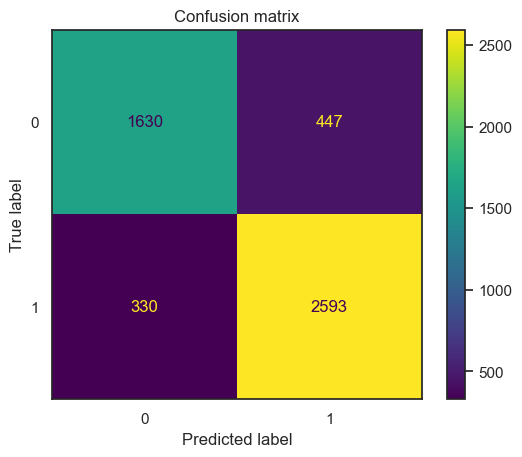

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import warnings
%matplotlib inline
import matplotlib.pyplot as plt

t_pred = lr_model.predict(D_test)
accuracy = accuracy_score(t_test, t_pred)
precision = precision_score(t_test, t_pred)
recall = recall_score(t_test, t_pred)
f1 = f1_score(t_test, t_pred)


sns.set_theme(style="white", palette=None)
lr_cm = confusion_matrix(t_test, t_pred)
disp = ConfusionMatrixDisplay(lr_cm)
disp.plot()
disp.ax_.set_title('Confusion matrix')
print("\nClassification Scores:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
plt.show()

The Recall metric is importantly focused to get rid of potential missing depressed students. According to this confusion matrix, the recall of 0.8871 indicates that the Logistic Regression Classifier correctly identifies roughly 89% of students who are truly depressed. Moreover, the precision of 85.3% along with the F1-score of 0.87 presents a high effectiveness and reliability in detecting cases of depression while keeping false alarms reasonably low. 

Last but not least, let's have a look at the below visualization for Logistic Regression hyper-parameters tunning process:

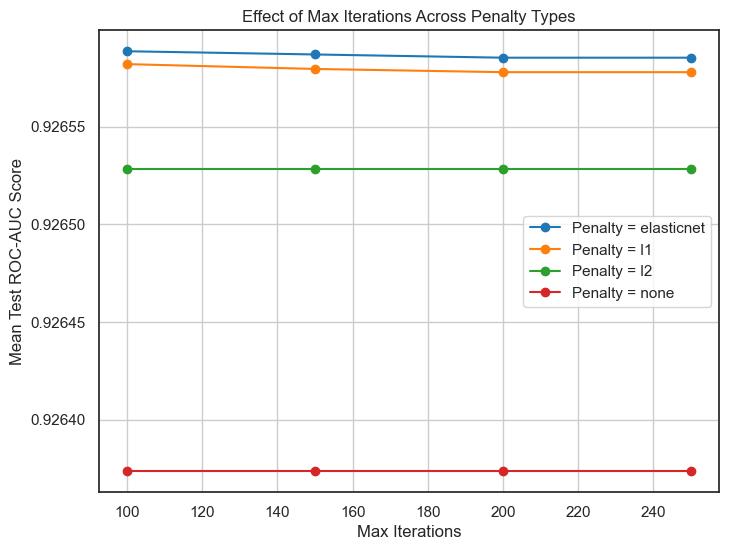

In [73]:
plt.figure(figsize=(8, 6))
lr_cv_result = pd.DataFrame(lr_model.cv_results_)

penalties = lr_cv_result.param_classifier__penalty.fillna("none").unique()
for penalty in sorted(penalties):
    subset = lr_cv_result[lr_cv_result.param_classifier__penalty.fillna("none") == penalty]
    means = subset.groupby('param_classifier__max_iter')['mean_test_score'].mean()
    plt.plot(means.index, means.values, marker='o', label=f'Penalty = {penalty}')

plt.xlabel('Max Iterations')
plt.ylabel('Mean Test ROC-AUC Score')
plt.title('Effect of Max Iterations Across Penalty Types')
plt.legend()
plt.grid(True)
plt.show()

Under the effect of number of training iterations across different penalty regulizations in tuning the LR model, it can be witnessed that the score remain stable throughout all specified iteration values. Thus, the number of iterations has little effect on model performance since the model converges early, but the selection of penalty matters. The elasticnet regularization consistently outperforms by yielding the highest ROC-AUC score, resulting in the best parameter for this dataset. L2 and L1 follow closely behind, with L1's performance difference to the elastic net's being more negligible than that of L2. The no regularization results in the lowest mean ROC-AUC score among all configurations.

#### ii. Kth Nearest Neighbour Classification

The K-Nearest Neighbours classification model is a supervised machine learning algorithm to predict the binary target feature. The concept of KNN helps classifies data points based on the majority label of the 'K' closest instances by employing distance metrics such as Eucledian or Manhattan. With a mix of numerical, binary, and categorical features, KNN algorithm is expected to make no assumption about the underlying data distribution, capturing nuanced relationships between data points that parametric model may overlook.

Integrating the same preprocessing and scalling set up as the Logistic Regression, K-Nearest Neighbours model is fine-tuned using a Pipeline. Followed by a GridSearch, the determined hyper-parameters includes the number of nearest neighbours in the training set that was considered when making prediction on depression situation besides the distance power p. This model looks to cover a wide range from very local like 1-3 neighbours to more general 15-20 points that finds the sweer spot between bias and variance. The power parameter are also tested whether different distance metrics may affect the predictive performance.

In [78]:
from sklearn.neighbors import KNeighborsClassifier

# Set up hyperparameter for tunning
param_grid = [
    {
        'classifier__n_neighbors': [1, 3, 5, 10, 15, 20],
        'classifier__p': [1, 2, 3, 4, 5]
    }    
]
 
# Create Pipeline
knn_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", KNeighborsClassifier())]
)
 
# Tunning using GridSearch object
knn_grid_model = GridSearchCV(knn_model, 
                            n_jobs=1, 
                            param_grid=param_grid, 
                            cv=cv_method,
                            scoring="roc_auc")


In [80]:
import os
import joblib

knn_model_name = 'knn_gridsearch_model.joblib'
file_path = os.path.join(os.getcwd(), knn_model_name)
if os.path.exists(file_path):
    print("Local file found. Loading decision tree model results: knn_model.")
    knn_model = joblib.load('knn_gridsearch_model.joblib')
else: 
    print("Local file not found. Fitting model and saving results as: knn_model.")
    knn_model = knn_grid_model.fit(D_train, t_train)
    joblib.dump(knn_model, 'knn_gridsearch_model.joblib')

knn_model

Local file found. Loading decision tree model results: knn_model.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=139, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sleep_duration',
                                                                          'dietary_habits',
                                                                          'degree']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ign...
                                                                          'family_mental_hist']),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'academic_pressure',
                                                                          'cgpa',
                                                                          'study_satisfaction',
                                                                          'work_study_hrs',
                                                                          'financial_stress'])])),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=1,
             param_grid=[{'classifier__n_neighbors': [1, 3, 5, 10, 15, 20],
                          'classifier__p': [1, 2, 3, 4, 5]}],
             scoring='roc_auc')

In [82]:
knn_model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sleep_duration',
                                                   'dietary_habits',
                                                   'degree']),
                                                 ('bin',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender',
                                                   'suicidal_thoughts',
                                                   'family_mental_hist']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'academic_pressure',
                                                   'cgpa', 'study_satisfaction',
                                                   'work_study_hrs',
                                                   'financial_stress'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=20, p=1))])

In [84]:
knn_model.best_params_

{'classifier__n_neighbors': 20, 'classifier__p': 1}

The 'best_params_' displays the best parameters combination between 20 neighbours with the Manhattan distance (p = 1) is believed to be the most effective to generate prediction. The dataset benefits from large value of neighbours to help smooth out prediction and is likely to be less sensitive to local pattern's noise.

The cros-validated ROC-AUC score are then calculated:

In [87]:
from sklearn.model_selection import cross_val_score

cv_results_knn_name = 'cross_validataion_KNN.joblib'
file_path = os.path.join(os.getcwd(), cv_results_knn_name)
if os.path.exists(file_path):
    cv_results_knn = joblib.load('cross_validataion_KNN.joblib')
    print("Local file found. Loading cross validation score result.\ncv_results_knn =")
    print(cv_results_knn)
else:    
    print("Local file not found. Computing CV scores and saving results.\ncv_results_knn =")
    cv_results_knn = cross_val_score(estimator=knn_model,
                                X=D_train,
                                y=t_train, 
                                cv=cv_method, 
                                scoring=scoring_metric)
    joblib.dump(cv_results_knn, 'cross_validataion_knn.joblib')
    print(cv_results_knn)

Local file found. Loading cross validation score result.
cv_results_knn =
[0.90826281 0.90533209 0.91582535 0.89943363 0.89962929]


In [89]:
cv_results_knn.mean()

0.9056966347123655

The KNN model achieves a mean ROC-AUC of about 0.906 throughout 5 different splitted folds. Thanks to all scores are over 0.90 with low variance, the results indicates the strong performance in KNN model's predictability, despite the fact that this cross-validated ROC-AUC scores are slightly lower than the previous Logistic Regression.

In [92]:
knn_model.score(D_test, t_test)

0.8998379363377565

The cross-validated ROC-AUC score on the training set is 0.9057 while the figure for testing set is recorded at 0.8998. Regardless that the observed scores trails slightly behind the Logistic Regression model, 0.9265 and 0.9188 respectively, this KNN's setup with 20 neightbours at Manhattan distance p = 1 is still competitive as a effective predictive model. The ROC-AUC scores also show the consistent performance in fitting KNN algorithm between training and testing dataset.

The performance of this KNN model was assessed using a confusion matrix constructed as follow:


Classification Scores:
Accuracy : 0.8324
Precision: 0.8294
Recall   : 0.8980
F1-score : 0.8624


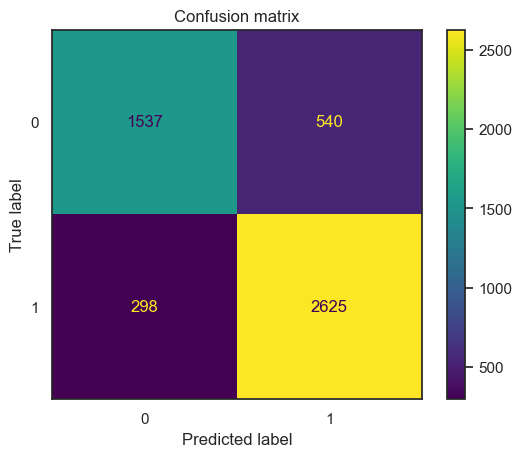

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import warnings
%matplotlib inline
import matplotlib.pyplot as plt

t_pred = knn_model.predict(D_test)
accuracy = accuracy_score(t_test, t_pred)
precision = precision_score(t_test, t_pred)
recall = recall_score(t_test, t_pred)
f1 = f1_score(t_test, t_pred)


sns.set_theme(style="white", palette=None)
knn_cm = confusion_matrix(t_test, t_pred)
disp = ConfusionMatrixDisplay(knn_cm)
disp.plot()
disp.ax_.set_title('Confusion matrix')
print("\nClassification Scores:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
plt.show()

According to this confusion matrix, the KNN classifier demonstrates a strong performance in identifying individuals with depression. 89.80% of truly depressed students were correctly identified by the model, represented via the Recall metric. As mention, this is a positive sign for mental health screening to help detect true positive cases. The model also avhieves an Accuracy of 83.24%, a Precision of 82.94%, and a F1-score of 86.24%. Noticeably, the slight drop in Precision means this KNN approach may make more false positive prediction than previous LR. In other words, more students who actually do not experience depression may be predicted to be depressed, causing a mislead. However, Recall is prioritized over Precision to avoid causing serious consequence because of misidentifying depressed student. In general, the model performs reliably and is suitable for early detection and screening purposes.

The plot below shows the results of the hyper-parameters tunning process based on distance metrics' interaction with various settings of neighbours:

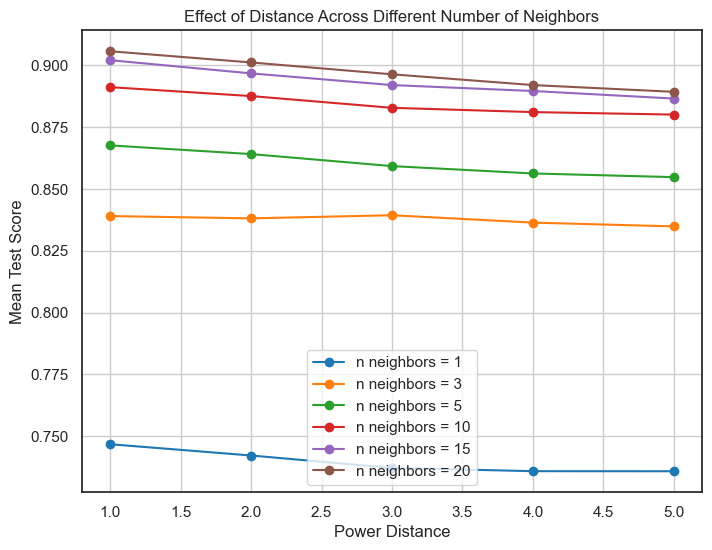

In [98]:
knn_cv_result = pd.DataFrame(knn_model.cv_results_)

plt.figure(figsize=(8,6))
for n in sorted(knn_cv_result.param_classifier__n_neighbors.unique()):
    subset = knn_cv_result[knn_cv_result.param_classifier__n_neighbors == n]
    means = subset.groupby('param_classifier__p')['mean_test_score'].mean()
    plt.plot(means.index, means.values, marker='o', label=f'n neighbors = {n}')
plt.xlabel('Power Distance')
plt.ylabel('Mean Test Score')
plt.title('Effect of Distance Across Different Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()


The Tunning process reveals that KNN model performs effectively with higher neighbour counts, especially higher than 15. It also suggests that smoother, generalized neighborhood patterns and axis-aligned feature differences are more predictive in this depression dataset. However, the higher number of neighbor sees a decrease in the mean test score when using higher-order distance while the lower n_neighbors shows significant sensitivity to power distance value which may result in overfitting or instability. As a result, the optimal model will reinforce a larger neighborhood and simpler distance measures to perform at its best for this classification task.

#### iii. Tree-based Models 

The following sections provide the details for the specification or parametrisation, the steps taken to perform, and the result of implementing two tree-based models to predict depression. The two models are Decision Tree without bagging and Random Forest, which is an emsemble method.

##### 1. Decision Tree

In addition, to the preprocessing and transforming steps stated previously in the beginning of this section, a pipeline is also initiated to fine tune the various hyperparameters of the decision tree model. The hyperparameters adjusted within this models are the max dept, the minimum samples required to split a node, the cost-complexity pruning alpha, and the impurity metric or criterion. The max dept parameter controls the number of splits in the tree. In order words, it controls the number of questions a tree can ask. High number of max dept may overfit the data during the training stage and reduces the model's ability to generalise. Using grid search, the model will fit with max dept from 10 to 50, at interval of 10s. `Minimum_sample_split` controls the minimum sample required to split a node in the tree. Higher value means less overfitting. The values that are considered for this parameters are 2, 3, 4, and 5. The cost-complexity alpha is a pruning parameters. It balances the impurity reduced by a split with the added cost of spliting the tree. The cost criterion becomes $Cost = Impurity + α* \text{Number of Terminal Nodes}$. The $\alpha$ values are 0, 0.01, 0.1, and 1. Finally, the criterion parameter controls the the impurity measure of the model. The gini index measures the impurity as: $$ G = \sum_{k=1}^K \hat{p}_{mk}(1-\hat{p}_{mk}) $$ while the cross-entropy, `entropy`, measures the impurity as: $$ D = -\sum_{k=1}^K \hat{p}_{mk}\log\hat{p}_{mk} $$ 


In [105]:
dt_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", DecisionTreeClassifier(random_state=139))
    ]
)

param_grid = [
    {
        'classifier__max_depth': [10, 20, 40, 50],
        'classifier__min_samples_split': [2, 3, 4, 5],
        'classifier__ccp_alpha': [0, 0.01, 0.1, 1],
        'classifier__criterion': ['gini', 'entropy']
    }    
]


dt_model = GridSearchCV(dt_pipeline, 
                        n_jobs=1, 
                        param_grid=param_grid, 
                        cv=cv_method,
                        refit=True,
                        scoring=scoring_metric)



In [107]:
import os
import joblib

dt_model_name = 'decision_tree_gridsearch_model.joblib'
file_path = os.path.join(os.getcwd(), dt_model_name)
if os.path.exists(dt_model_name):
    print("Local file found. Loading decision tree model results: dt_model.")
    dt_model = joblib.load('decision_tree_gridsearch_model.joblib')
else: 
    print("Local file not found. Fitting model and saving results as: dt_model.")
    dt_model = dt_model.fit(D_train, t_train)
    joblib.dump(dt_model, 'decision_tree_gridsearch_model.joblib')

dt_model

Local file found. Loading decision tree model results: dt_model.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=139, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sleep_duration',
                                                                          'dietary_habits',
                                                                          'degree']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ign...
                                                                          'academic_pressure',
                                                                          'cgpa',
                                                                          'study_satisfaction',
                                                                          'work_study_hrs',
                                                                          'financial_stress'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=139))]),
             n_jobs=1,
             param_grid=[{'classifier__ccp_alpha': [0, 0.01, 0.1, 1],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [10, 20, 40, 50],
                          'classifier__min_samples_split': [2, 3, 4, 5]}],
             scoring='roc_auc')

The decision tree model was fit to the data using `GridSearchCV`, which incoperate cross-validation in the data. The best parameter found by the grid search was `ccp_alpha = 0.01`, `criterion = gini`, `max_dept = 10`, `min_samples_split = 2`. The best model is the one with no pruning and lower complexity, indicating that complex models may overfit the training folds but perform worse during cross-validation. The best score, which is the averge cross-validation AUC score of the best decision tree estimator, is 0.817.   

In [110]:
dt_best_parameter = dt_model.best_params_
dt_best_score = dt_model.best_score_

print(f"Best Decision Tree Parameter : {dt_best_parameter}")
print(f"Best Decision Tree Score : {dt_best_score}")

Best Decision Tree Parameter : {'classifier__ccp_alpha': 0.01, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_split': 2}
Best Decision Tree Score : 0.8781437547035702


The following shows the scores across all the hold-out folds of the cross-validation using the best estimator of the decision tree model found above.

In [113]:
from sklearn.model_selection import cross_val_score

cv_results_dt_name = 'cross_validataion_DT.joblib'
file_path = os.path.join(os.getcwd(), cv_results_dt_name)
if os.path.exists(cv_results_dt_name):
    cv_results_dt = joblib.load('cross_validataion_DT.joblib')
    print("Local file found. Loading cross validation score result.\ncv_results_dt =")
    print(cv_results_dt)
else:    
    print("Local file not found. Computing CV scores and saving results.\ncv_results_dt =")
    cv_results_dt = cross_val_score(estimator=dt_model,
                                X=D_train,
                                y=t_train, 
                                cv=cv_method, 
                                scoring=scoring_metric)
    joblib.dump(cv_results_dt, 'cross_validataion_DT.joblib')
    print(cv_results_dt)

Local file found. Loading cross validation score result.
cv_results_dt =
[0.88573087 0.87906061 0.90176089 0.86043662 0.86372979]


The following figure shows the relative performance of the hyperparameters `max_dept` and `min_samples_split` across all levels of `ccp_alpha`, regardless of the criterion. At `alpha = 0.00`, there is variability in the performance of the model. The best model was `max_dept = 10` with `min_samples_split = 5`.  However, with pruning introduced the model performance become worse after `ccp_alpha > 0.01`. At `ccp_alpha = 0.01`, the graph shows only 1 line. This is also where the test score is the highest. This indicates that, across all other hyperparameters, at `ccp_alpha = 0.01`, the performance is the same. Therefore, the best model is the simplest one at `max_depth = 10` and `min_samples_split = 2`. 

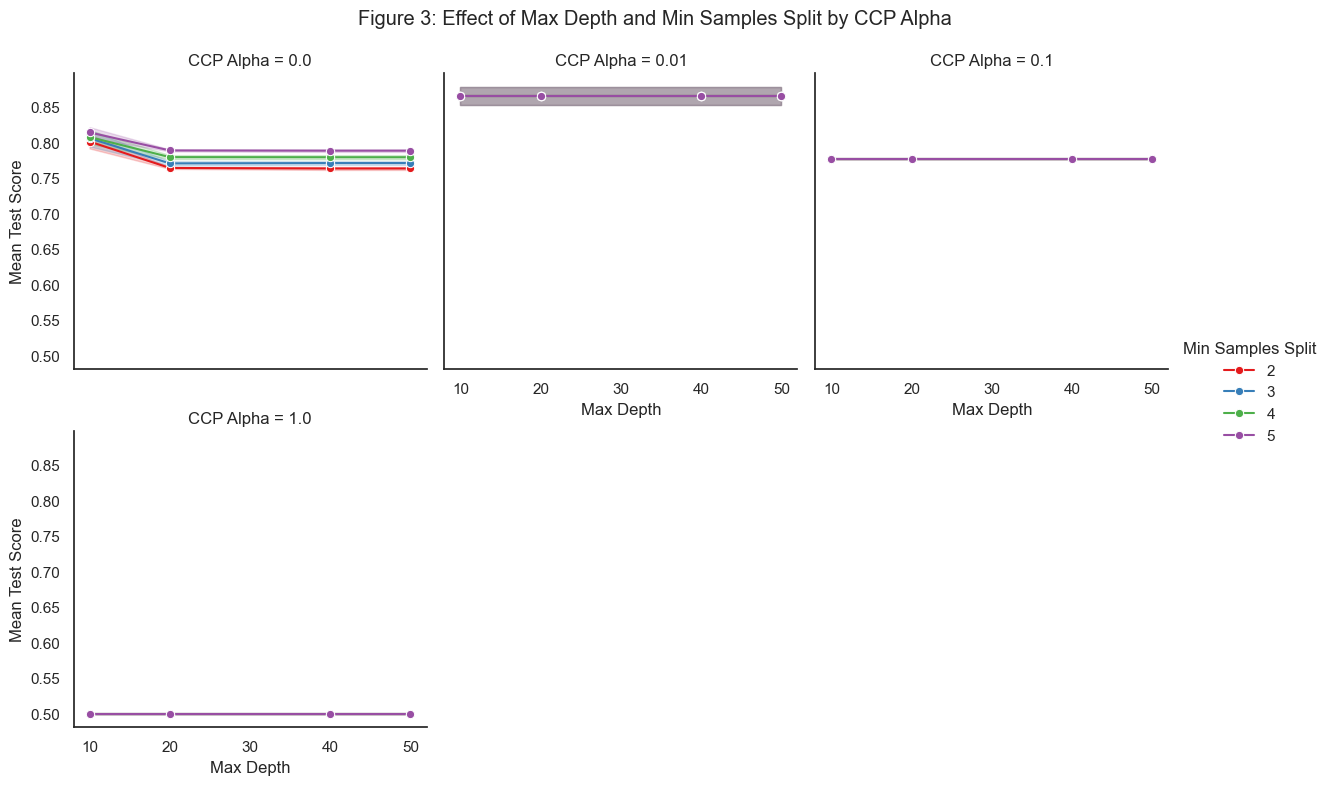

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

dt_cv_result = pd.DataFrame(dt_model.cv_results_)

# Replace the param columns with simpler names for easier plotting:
dt_cv_result.rename(columns={
    'param_classifier__min_samples_split': 'min_samples_split',
    'param_classifier__max_depth': 'max_depth',
    'param_classifier__ccp_alpha': 'ccp_alpha'
}, inplace=True)

# Convert ccp_alpha to string to avoid too many unique facets if it's continuous:
dt_cv_result['ccp_alpha'] = dt_cv_result['ccp_alpha'].astype(str)

g = sns.FacetGrid(dt_cv_result, col='ccp_alpha', col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x='max_depth', y='mean_test_score', hue='min_samples_split', palette='Set1', marker='o')

g.add_legend(title='Min Samples Split')
g.set_axis_labels('Max Depth', 'Mean Test Score')
g.set_titles('CCP Alpha = {col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Figure 3: Effect of Max Depth and Min Samples Split by CCP Alpha')

plt.show()

The test score for `cc_alpha = 0.01` is checked to verify as follow:

In [119]:
dt_cv_result = pd.DataFrame(dt_model.cv_results_)

# Find the max mean_test_score
max_score = dt_cv_result['mean_test_score'].max()

# Filter rows with the highest mean_test_score
best_params_df = dt_cv_result[dt_cv_result['mean_test_score'] == max_score]
best_params_df = best_params_df[['param_classifier__max_depth','param_classifier__min_samples_split','param_classifier__ccp_alpha','mean_test_score']]

best_params_df

,param_classifier__max_depth,param_classifier__min_samples_split,param_classifier__ccp_alpha,mean_test_score
48,10,2,0.01,0.878144
49,10,3,0.01,0.878144
50,10,4,0.01,0.878144
51,10,5,0.01,0.878144
52,20,2,0.01,0.878144
53,20,3,0.01,0.878144
54,20,4,0.01,0.878144
55,20,5,0.01,0.878144
56,40,2,0.01,0.878144
57,40,3,0.01,0.878144


Using the optimised model, the target value, or rather, the probability of the target value in the test set, is predicted. Then, the AUC score is calculated for the test set. The AUC score was 0.870 which is extremely close to the best score obtain from fitting the data. This implies that the model generalises well and gives good predictions.

In [122]:
from sklearn.metrics import roc_auc_score

y_prob = dt_model.predict_proba(D_test)[:,1]

roc_auc_dt = roc_auc_score(t_test, y_prob)
roc_auc_dt

0.8704427933720427

A confusion matrix is created for the predicted target values of the test set. Using the default `.predict()` function the treshold implemented is 0.5. Other classification measures are calculated from the confusion matrix including, accuracy, precision, recall and F1-score. The metric of interest is `recall`, which is 0.8050. This implies the model was able to correctly identify 80.50% of all depressed cases. While not perfect, this level of recall is generally considered high in real life practice. F1-score which is the harmonic mean between recall and precision is 0.8259. Accuracy and precision is lower than recall at 0.8016 and 0.8479, repsectively. This suggests that the model predicted less false positives than false negative. For health care professionals, this model is good as correctly identifying depressed individuals may hold the same significance as avaioding to identify non-depressed individual as depressed because this can lead to unnecesary concerns and fear for the individual should further actions be taken for or on them. 


Classification Scores:
Accuracy : 0.8016
Precision: 0.8479
Recall   : 0.8050
F1-score : 0.8259


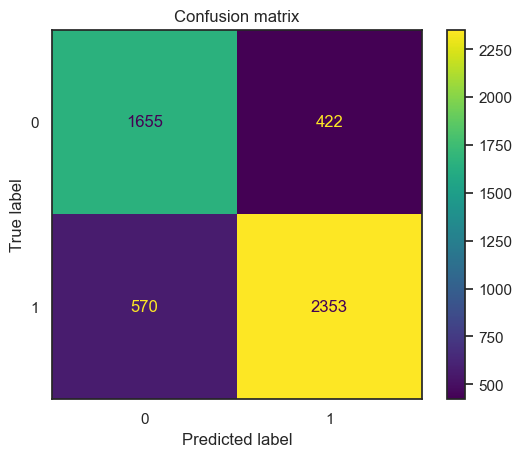

In [125]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import warnings
%matplotlib inline
import matplotlib.pyplot as plt

t_pred = dt_model.predict(D_test)
accuracy = accuracy_score(t_test, t_pred)
precision = precision_score(t_test, t_pred)
recall = recall_score(t_test, t_pred)
f1 = f1_score(t_test, t_pred)


sns.set_theme(style="white", palette=None)
dt_cm = confusion_matrix(t_test, t_pred)
disp = ConfusionMatrixDisplay(dt_cm)
disp.plot()
disp.ax_.set_title('Confusion matrix')
print("\nClassification Scores:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
plt.show()

##### 2. Random Forest 

Similarly, `GridSearchCV()` is used to find the optimal combination of hyperparameters for the random forest model. . Two parameters from the decision trees are kept, `max_depth` and `min_samples_split`. This model also allows for bootstrapping. In order words, the random forest model will create numerous trees, and each tree will be trained on a sample of the training set with replacement. Other parameters unique to the random forest are introduced such as `n_estimators`, which controls the number of trees or the size of the 'forest', `max_features`, which is the method used to compute the number of features the tree is allowed to select from at each split, and `min_samples_leaf`, which controls the number of samples required at the terminal nodes. Higher `n_estimators` and low `min_samples_leaf` may risk overfitting with random forest. The difference between the two method to select `max_features` is that the `auto` uses $\sqrt{p}$, while `log2` uses $\log_2{p}$, where p is the total number of the descriptive features. 

In [129]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier",  RandomForestClassifier(random_state=139, bootstrap=True))
    ]
)
        
rf_param_grid = [
    {
        'classifier__max_depth': [10, 20, 40, 50],
        'classifier__min_samples_split': [2, 3, 4, 5],
        'classifier__n_estimators': [50, 100, 150],
        'classifier__max_features':['auto','log2'],
        'classifier__min_samples_leaf':[1, 2, 3, 4, 5]
    }    
    
]

rf_model = GridSearchCV(rf_pipeline, 
                        n_jobs=1, 
                        param_grid=rf_param_grid, 
                        cv=cv_method,
                        refit=True,
                        scoring=scoring_metric)

In [131]:
import os
import joblib

rf_model_name = 'random_forest_gridsearch_model.joblib'
file_path = os.path.join(os.getcwd(), rf_model_name)
if os.path.exists(rf_model_name):
    print("Local file found. Loading decision tree model results: rf_model.")
    rf_model = joblib.load('random_forest_gridsearch_model.joblib')
else: 
    print("Local file not found. Fitting model and saving results as: rf_model.")
    rf_model = rf_model.fit(D_train, t_train)
    joblib.dump(rf_model, "random_forest_gridsearch_model.joblib")

rf_model

Local file found. Loading decision tree model results: rf_model.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=139, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sleep_duration',
                                                                          'dietary_habits',
                                                                          'degree']),
                                                                        ('bin',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ign...
                                                                          'study_satisfaction',
                                                                          'work_study_hrs',
                                                                          'financial_stress'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=139))]),
             n_jobs=1,
             param_grid=[{'classifier__max_depth': [10, 20, 40, 50],
                          'classifier__max_features': ['auto', 'log2'],
                          'classifier__min_samples_leaf': [1, 2, 3, 4, 5],
                          'classifier__min_samples_split': [2, 3, 4, 5],
                          'classifier__n_estimators': [50, 100, 150]}],
             scoring='roc_auc')

The random forest model was fitted to the data using the parameters above. The optimal random forest model given these combinations of hyperparameters are `classifier__max_depth = 20`, `classifier__max_features = log2`, `classifier__min_samples_leaf = 4`, `classifier__min_samples_split = 2`, `classifier__n_estimators = 150`. The mean cross-validation score using this optimal model for the training set is 0.9226, which seems to be a great improvement on the single decision tree model. This is as expected as Random Forest generally outperforms Decision Tree.  

In [134]:
rf_best_parameter = rf_model.best_params_
rf_best_score = rf_model.best_score_

print(f"Best Decision Tree Parameter : {rf_best_parameter}")
print(f"Best Decision Tree Score : {rf_best_score}")

Best Decision Tree Parameter : {'classifier__max_depth': 20, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 150}
Best Decision Tree Score : 0.922583146601157


The following plot shows the performance of the random forest model during the parameters optimisation process. With `min_samples_leaf = 1` the model appears to be overfitting, evident from the variability in the performance, especially across different `min_samples_split`. With each increase in `min_samples_split`, the model appears to perform better up until `min_samples_leaf = 4`, after which performance drops off. However, this plot is incongruent with the best paramters found earlier. It seems to suggests that the best `max_dept` is 10 as opposed to 20. A simple reason is that the `mean_test_score` computed in this plot considers all `mean_test_score` from other parameters such as `min_samples_leaf`, for instance, for which the the `mean_test_score` at `max_depth = 20` could be lower for other values of the parameters beside the optimal value which can decrease the overall average.

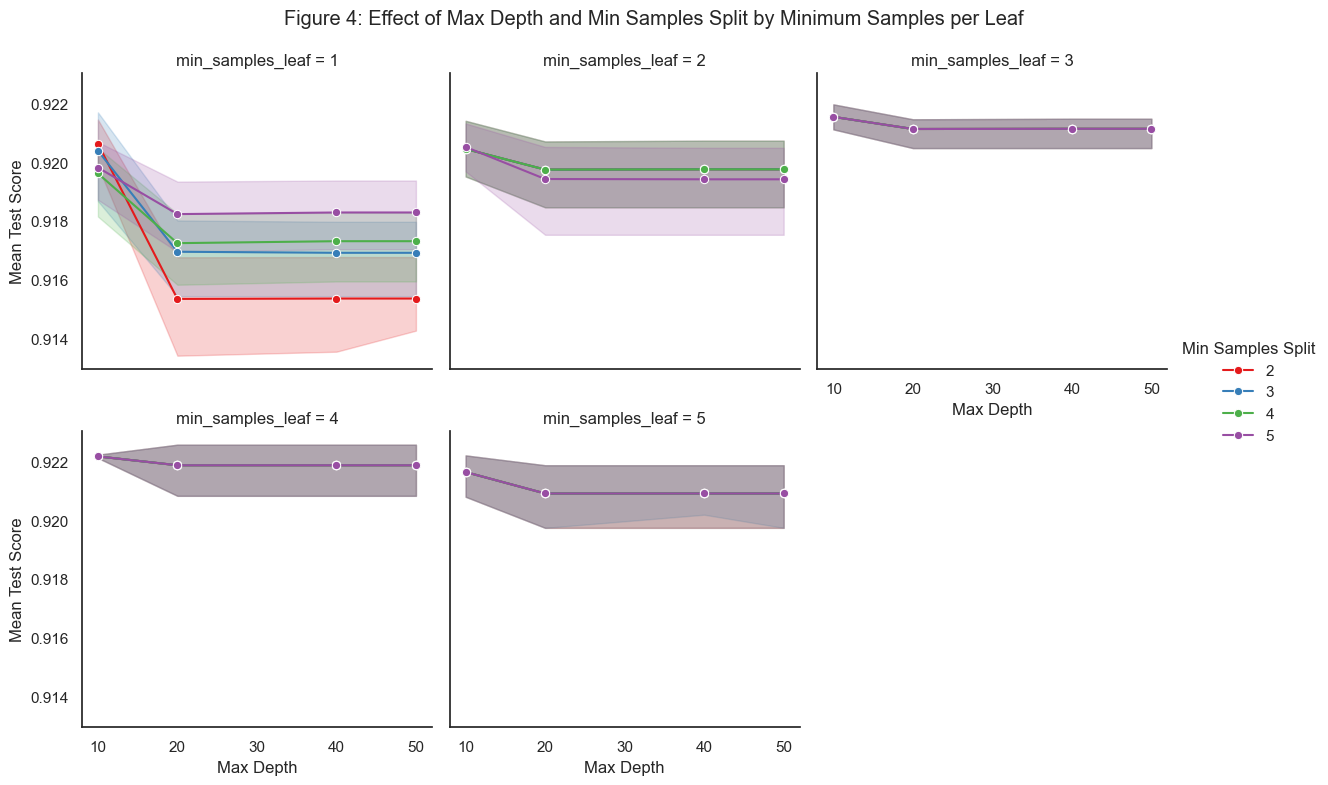

In [137]:


import seaborn as sns
import matplotlib.pyplot as plt

rf_cv_result = pd.DataFrame(rf_model.cv_results_)

# Replace the param columns with simpler names for easier plotting:
rf_cv_result.rename(columns={
    'param_classifier__min_samples_split': 'min_samples_split',
    'param_classifier__max_depth': 'max_depth',
    'param_classifier__n_estimators': 'n_estimators',
    'param_classifier__max_features': 'max_features',
    'param_classifier__min_samples_leaf': 'min_samples_leaf'
}, inplace=True)

# Convert ccp_alpha to string so that it becomes cateogrical:
rf_cv_result['min_samples_leaf'] = rf_cv_result['min_samples_leaf'].astype(str)

g = sns.FacetGrid(rf_cv_result, col='min_samples_leaf', col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x='max_depth', y='mean_test_score', hue='min_samples_split', palette='Set1', marker='o')

g.add_legend(title='Min Samples Split')
g.set_axis_labels('Max Depth', 'Mean Test Score')
g.set_titles('min_samples_leaf = {col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Figure 4: Effect of Max Depth and Min Samples Split by Minimum Samples per Leaf')

plt.show()

Since it is known that `min_samples_leaf = 4` provides the best performance, the data can be filtered for `min_samples_leaf = 4`, and the performance of other parameters can be added to the plot. In *figure 5*, another variable `n_estimators` is added to the plot. At `n_estimator = 50`, increasing `max_depth` will decrease performance. The performance of the models at `n_estimator = 100` for all `min_samples_split` at `min_sample_leaf = 4` were similar but their performance were lower than the models with `n_estimator = 150`. At this point, the performance is optimal and increasing `max_depth` and `min_samples_split` will not affect the performance further. This shows that the optimal model is the simplest one with `min_samples_split = 2`, `min_sample_leaf = 4`, and `max_depth = 20`.

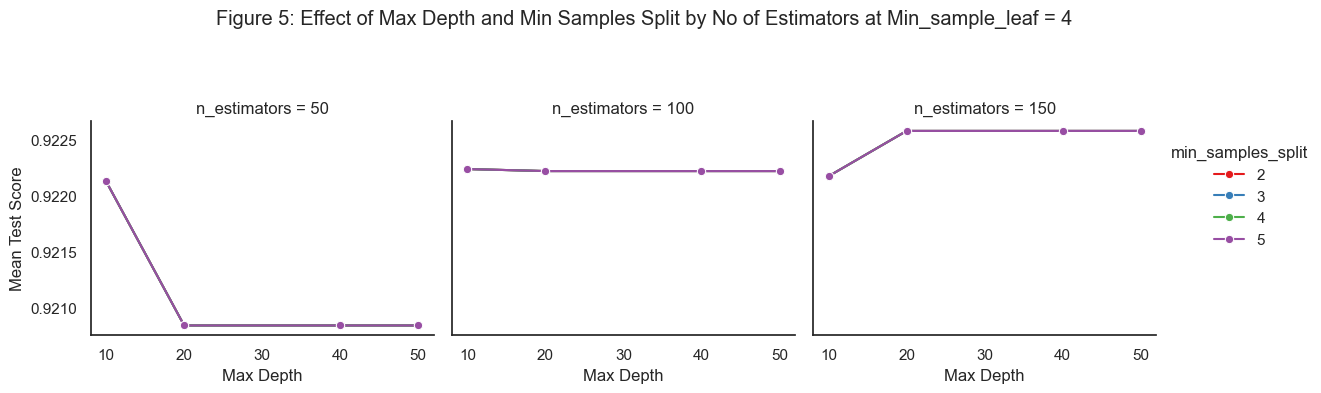

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

rf_cv_result = pd.DataFrame(rf_model.cv_results_)

# Replace the param columns with simpler names for easier plotting:
rf_cv_result.rename(columns={
    'param_classifier__min_samples_split': 'min_samples_split',
    'param_classifier__max_depth': 'max_depth',
    'param_classifier__n_estimators': 'n_estimators',
    'param_classifier__max_features': 'max_features',
    'param_classifier__min_samples_leaf': 'min_samples_leaf'
}, inplace=True)

# Convert ccp_alpha to string so that it becomes cateogrical:
rf_cv_result['min_samples_leaf'] = rf_cv_result['min_samples_leaf'].astype(str)
rf_cv_result['n_estimators'] = rf_cv_result['n_estimators'].astype(str)

rf_cv_result = rf_cv_result[rf_cv_result['min_samples_leaf'] == '4']

g = sns.FacetGrid(rf_cv_result, col='n_estimators', col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x='max_depth', y='mean_test_score', hue='min_samples_split', palette='Set1', marker='o')

g.add_legend(title='min_samples_split')
g.set_axis_labels('Max Depth', 'Mean Test Score')
g.set_titles('n_estimators = {col_name}')
plt.subplots_adjust(top=0.7)
g.fig.suptitle('Figure 5: Effect of Max Depth and Min Samples Split by No of Estimators at Min_sample_leaf = 4')

plt.show()

The explanation above can simply be verified by examining the rows of results with the maximum test score as follows:

In [143]:
rf_cv_result = pd.DataFrame(rf_model.cv_results_)

# Find the max mean_test_score
max_score = rf_cv_result['mean_test_score'].max()

# Filter rows with the highest mean_test_score
best_params_df = rf_cv_result[rf_cv_result['mean_test_score'] == max_score]
best_params_df = best_params_df[['param_classifier__max_depth',
                                 'param_classifier__min_samples_split',
                                 'param_classifier__n_estimators',
                                 'param_classifier__max_features',
                                 'param_classifier__min_samples_leaf',
                                 'mean_test_score']]

best_params_df

,param_classifier__max_depth,param_classifier__min_samples_split,param_classifier__n_estimators,param_classifier__max_features,param_classifier__min_samples_leaf,mean_test_score
218,20,2,150,log2,4,0.922583
221,20,3,150,log2,4,0.922583
224,20,4,150,log2,4,0.922583
227,20,5,150,log2,4,0.922583
338,40,2,150,log2,4,0.922583
341,40,3,150,log2,4,0.922583
344,40,4,150,log2,4,0.922583
347,40,5,150,log2,4,0.922583
458,50,2,150,log2,4,0.922583
461,50,3,150,log2,4,0.922583


The following shows the scores across all the hold-out folds of the cross-validation using the best estimator of the decision tree model found above.

In [146]:
from sklearn.model_selection import cross_val_score
import os

cv_results_rf_name = 'cross_validataion_RF.joblib'
file_path = os.path.join(os.getcwd(), cv_results_rf_name)
if os.path.exists(cv_results_rf_name):
    cv_results_rf = joblib.load('cross_validataion_RF.joblib')
    print("Local file found. Loading cross validation score result.\ncv_results_rf =")
    print(cv_results_rf)
else:    
    print("Local file not found. Computing CV scores and saving results.\ncv_results_rf =")
    cv_results_rf = cross_val_score(estimator=rf_model,
                                X=D_train,
                                y=t_train, 
                                cv=cv_method, 
                                scoring=scoring_metric)
    joblib.dump(cv_results_rf, "cross_validataion_RF.joblib")
    print(cv_results_rf)

Local file found. Loading cross validation score result.
cv_results_rf =
[0.92979452 0.92478925 0.93107198 0.91705077 0.90811657]


Again, using the optimal model, the probability of getting the target value (depressed) is calculated for the test sample, and the AUC score was 0.9109. This score is similar to the traning set validation score, which implies that the model generalises well on unseen data.

In [149]:
from sklearn.metrics import roc_auc_score

y_prob = rf_model.predict_proba(D_test)[:,1]

roc_auc_rf = roc_auc_score(t_test, y_prob)
roc_auc_rf

0.9109931344897795

The confusion matrix is also created for the predicted values of the test set. Using the optimal random forest model, the scores are higher for all metrics. Accuracy, precision, recall, and F1-score were 0.8346, 0.8441, 0.8796, and 0.8615, respectively. Noticebly, recall increased by 0.079 comparing to the decision tree method. The random forest can correctly identify 87.96% of all the positive cases.


Classification Scores:
Accuracy : 0.8346
Precision: 0.8441
Recall   : 0.8796
F1-score : 0.8615


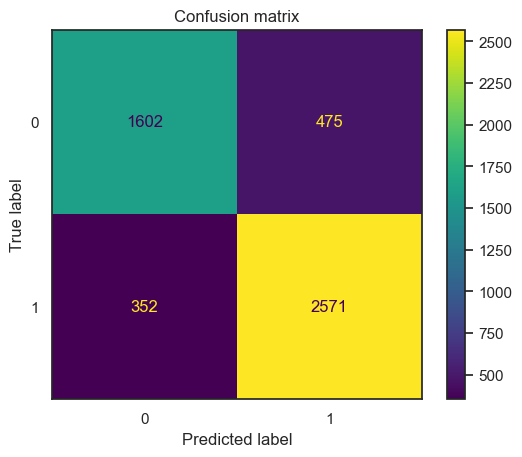

In [152]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import warnings
%matplotlib inline
import matplotlib.pyplot as plt

t_pred = rf_model.predict(D_test)
accuracy = accuracy_score(t_test, t_pred)
precision = precision_score(t_test, t_pred)
recall = recall_score(t_test, t_pred)
f1 = f1_score(t_test, t_pred)


sns.set_theme(style="white", palette=None)
rf_cm = confusion_matrix(t_test, t_pred)
disp = ConfusionMatrixDisplay(rf_cm)
disp.plot()
disp.ax_.set_title('Confusion matrix')
print("\nClassification Scores:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
plt.show()

### 2.3 Neural Network (NN)

##### i. Modelling Discussion

In this study, a Neural Network (NN) was constructed and tuned to predict depression status based on a set of descriptive features. The objective was to maximize predictive performance using ROC-AUC as the main evaluation metric, as it effectively captures the trade-off between true positive and false positive rates, especially for imbalanced datasets.

First and foremost, the target feature will be reshape into two-dimensional array to fit in the Neural Network modeling process after spliting the dataset into separated training and testing sets. TensorFlow and Keras are the main libraries implemented to construct the feedforward neural network architecture with two hidden layers. The first layer contained five neurons with ReLU activation followed by a drop-out rate of 0.05. The activation function is selected to be beneficial for its computational efficiency and ability to mitigate vanishing gradients while the drop-out rate determines the overfitting reduction when training neurons randomly. Next, the second layer comprise of five neuron units as well, whilst, using the Tand activation function. It is believed to evaluate the outputs in the range from -1 to 1 to promote zero-centered distribution. No drop-out is specified for this second layer in the base model to enswure the network's capability of fully leveraging learned representations. Importantly, the "sigmoid" activation function has been assigned to the output layer to produce a probability values between 0 and 1, making it ideal for binary classification. Especially, with the input layer, the ColumnTransformer is utilized from previous models to apply the preprocessor that combine Pipelines for categorical, numerical, and binary features.

The model is then compiled using the binary cross-entropy loss function and an optimizer using stochastic gradient descent (SGD) with 0.05 momentum and a learning rate. To be more specific, the learning rate has been computed following an exponential decay schedule, starting at 0.01 and decaying every 10 thousand steps with a rate of 0.9. On top of that, the momentum value help accelerate convergence and escape local minima. As a result, thie adaptive learning rate allow the model to make large update initially and smaller adjustments as it converged using the ROC-AUC scoring method throughout the training and validating procedure.

The key component of the modeling is the use of early stopping, which monitored the validation loss and halted training if no improvement is observed after 10 consecutive epochs. Mentioning about epochs, the parameter was first set at 25, however, the risks of underfitting is considerably high forcing it to be changed to higher values, for example at 60. Apparently, the val_loss at the 61th epoch show an increase to 0.3460 while the 60th's is 0.3669, therefore, the chosen epoch counts stop at 60. Larger batch size, for instance, 125 or 150, show faster convergence but poorer generalizational while smaller values like 30 or 60 may increase training time without a clear performance benefit. Consequently, the batch size of 100 has been selected for this Neural Network model.

The tunning phase involves modifying seven hyper-parameters to asses their influence on model performance, listing as number of units in hidden layers, drop-out rates, epochs counts, batch size, activation functions for each layer, learning rates, and optimizer. Once training is completed, predictions will be generated for the testing set, then store the result in a DataFrame to calculate the ROC-AUC score. The ROC-AUC score represent the model's real-word performance on unseen data, confirming its stability and reliability. With the metric equals to 0.9167, this model is competitive in comparison to the rest four above models LR, KNN, DT, and RF.

In summary, the constructed NN model has successfully capture the complexity between the relationship of data points. It also demonstrated strong predictive power via appropriate tuning and evaluation. The choice of layer architecture, optimizer settings, and regularization techniques are defined thanks to empirical experiments, resulting in a rebust model ready in practical application.

##### ii. NN Model Fine-tuning

In [44]:
# Reshape the target feature into 2D array then split datasets again 
X_train, X_test, y_train, y_test = train_test_split(depress2[descriptive_cols], 
                                                    depress2["depression"].values.reshape(-1, 1), 
                                                    test_size=0.5,
                                                    stratify = depress2["depression"],
                                                    random_state=139)

In [45]:
# Define hyper-parameters
layer1_units = 5
layer2_units = 5

epochs = 60
batch_size = 100

layer1_activation = 'relu'
layer2_activation = 'tanh'
output_activation = 'sigmoid'

layer1_dropout_rate = 0.05
layer2_dropout_rate = 0.00

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [46]:
# Set up an empty deep learning model
def model_factory(input_dim, layer1_units, layer2_units):
    # Learning rate schedule and optimizer
    lr_schedule = schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.9
    )
    optimizer = SGD(learning_rate=lr_schedule, momentum=0.5)

    model = Sequential()
    model.add(Dense(layer1_units, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.05))
    model.add(Dense(layer2_units, activation='tanh'))
    model.add(Dropout(0.00))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC(name='roc_auc')])
    return model

In [47]:
nn_model_test = model_factory(X_train_processed.shape[1], layer1_units, layer2_units)
nn_model_test.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 146 (584.00 B)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

nn_history_test = nn_model_test.fit(X_train_processed, 
                                 y_train,
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 verbose=1, 
                                 shuffle=True,
                                 validation_data=(X_test_processed, y_test),
                                 callbacks=[early_stop])

Epoch 1/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - loss: 0.6999 - roc_auc: 0.4665 - val_loss: 0.6817 - val_roc_auc: 0.5336
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - loss: 0.6766 - roc_auc: 0.5691 - val_loss: 0.6663 - val_roc_auc: 0.6767
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - loss: 0.6616 - roc_auc: 0.6999 - val_loss: 0.6541 - val_roc_auc: 0.7675
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - loss: 0.6487 - roc_auc: 0.7752 - val_loss: 0.6422 - val_roc_auc: 0.7802
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 0.6397 - roc_auc: 0.7715 - val_loss: 0.6290 - val_roc_auc: 0.7877
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - loss: 0.6240 - roc_auc: 0.7852 - val_loss: 0.6140 - val_roc_auc: 0.7968
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 0.6115 - roc_auc: 0.7884 - val_loss: 0.5971 - val_roc_auc: 0.8071
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - loss: 0.5956 - roc_auc: 0.8086 - val_loss: 0.5787 - val_roc_auc:

In [49]:
# Get keys
nn_history_test.history.keys()

dict_keys(['loss', 'roc_auc', 'val_loss', 'val_roc_auc'])

In [50]:
# Get keys and configurations of the fitted NN
nn_model_test.optimizer.get_config()

{'name': 'SGD',
 'learning_rate': {'module': 'keras.optimizers.schedules',
  'class_name': 'ExponentialDecay',
  'config': {'initial_learning_rate': 0.01,
   'decay_steps': 10000,
   'decay_rate': 0.9,
   'staircase': False,
   'name': 'ExponentialDecay'},
  'registered_name': None},
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'loss_scale_factor': None,
 'gradient_accumulation_steps': None,
 'momentum': 0.5,
 'nesterov': False}

In [51]:
# Predictive performance on testing set
nn_model_output = nn_model_test.predict(X_test_processed).astype(float)

# Set threshold of 0.5 for classification
y_pred = np.where(nn_model_output < 0.5, 0, 1)

# Convert result to dataframe
result_test = pd.DataFrame()
result_test['actual_depression'] = y_test.flatten()
result_test['predicted_depression'] = y_pred

result_test.head()

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


,actual_depression,predicted_depression
0,0,0
1,0,1
2,1,1
3,0,0
4,0,1


In [52]:
# Get prediction probabilities for test set
y_proba = nn_model_test.predict(X_test_processed).flatten()

# Calculate ROC-AUC 
roc_auc_score(y_test, y_proba)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


0.9167627919357226

In [54]:
# Define plot function for the fit
def plot_history(history): 
    train_auc = history.history.get('roc_auc')
    val_auc = history.history.get('val_roc_auc')
    
    if train_auc is None or val_auc is None:
        print("AUC values not found in history. Available keys are:")
        print(history.history.keys())
        return

    plt.figure(figsize=(8, 6))
    plt.plot(train_auc, label='Train ROC-AUC')
    plt.plot(val_auc, label='Validation ROC-AUC')
    plt.title('Model ROC-AUC Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('AUC Score')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

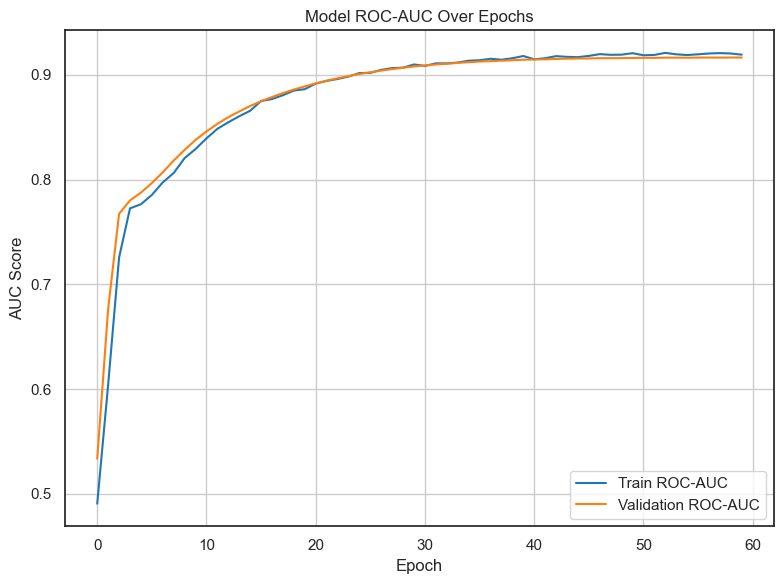

In [55]:
# Plot the NN model
plot_history(nn_history_test)

## 3. Model Comparison

In [154]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

dt_pred = dt_model.predict(D_test)
rf_pred = rf_model.predict(D_test)
lr_pred = lr_model.predict(D_test)
knn_pred = knn_model.predict(D_test)

results_df = pd.DataFrame({
    "Accuracy": [
        accuracy_score(t_test,lr_pred),
        accuracy_score(t_test,knn_pred),
        accuracy_score(t_test,dt_pred),
        accuracy_score(t_test,rf_pred)
    ],
    "Precision": [
        precision_score(t_test,lr_pred),
        precision_score(t_test,knn_pred),
        precision_score(t_test,dt_pred),
        precision_score(t_test,rf_pred)
    ],
    "Recall": [
        recall_score(t_test,lr_pred),
        recall_score(t_test,knn_pred),
        recall_score(t_test,dt_pred),
        recall_score(t_test,rf_pred)
    ],
    "F1-score": [
        f1_score(t_test,lr_pred),
        f1_score(t_test,knn_pred),
        f1_score(t_test,dt_pred),
        f1_score(t_test,rf_pred)
    ],
    "ROC_AUC Score": [
     roc_auc_score(t_test, lr_model.predict_proba(D_test)[:,1]),
     roc_auc_score(t_test, knn_model.predict_proba(D_test)[:,1]),
     roc_auc_score(t_test, dt_model.predict_proba(D_test)[:,1]),
     roc_auc_score(t_test, rf_model.predict_proba(D_test)[:,1])      
    ]
},
    index = ["Logistic Regression","K-nearest Neighbour","Decision Tree","Random Forest"])


print(results_df)

                     Accuracy  Precision    Recall  F1-score  ROC_AUC Score
Logistic Regression    0.8446   0.852961  0.887102  0.869696       0.918870
K-nearest Neighbour    0.8324   0.829384  0.898050  0.862352       0.899838
Decision Tree          0.8016   0.847928  0.804995  0.825904       0.870443
Random Forest          0.8346   0.844058  0.879576  0.861451       0.910993


The table above summarises all the performance metrics of the optimal combination of parameters of each model. Overall, the comparison shows that the performance of the models are similar with the exception of random forest. The best model based on the combination of AUC score and recall was the logistic regression with AUC score of 0.918870 and recall of 0.8871, respectively. The second best model was the Kth nearest neighbour model followed by the random forest model. This comparison shows that simpler model may be more effective. This is especially the case considering the time taken to perform each model. Logistic regression and K-nearest Neighbour took the shortest time, each less than 5 minutes. Random forest, however, took approximately 20 minutes. In a time-sensitive circumstance, logistic regression is clearly the best choice. It should be noted that introducing scaler might help improve the performance of the logistic model but does not necessarily improve KNN or Random Forest. Simple and clean data may also allow logistic regression to outperformance other models. The models may perform differently under different circumstances.   

In [171]:
cv_results_lr = joblib.load("cross_validataion_LR.joblib")
cv_results_knn = joblib.load("cross_validataion_knn.joblib")
cv_results_dt= joblib.load("cross_validataion_DT.joblib")
cv_results_rf = joblib.load("cross_validataion_RF.joblib")

In [173]:
from scipy import stats
comparisons = [
    ("Decision Tree vs Random Forest", cv_results_dt, cv_results_rf),
    ("Decision Tree vs Logistic Regression", cv_results_dt, cv_results_lr),
    ("Decision Tree vs KNN", cv_results_dt, cv_results_knn),
    ("Logistic Regression vs Random Forest", cv_results_lr, cv_results_rf),
    ("Logistic Regression vs KNN", cv_results_lr, cv_results_knn),
    ("KNN vs Random Forest", cv_results_knn, cv_results_rf)
]

ttest_results = []

for name, x, y in comparisons:
    t_stat, p_value = stats.ttest_rel(x, y)
    ttest_results.append(
        {
        "comparison": name,
        "T-Statistic": round(t_stat,5),
        "P-value": round(p_value,5)
        })

ttest_df = pd.DataFrame(ttest_results).sort_values(by="P-value", ascending=False)
ttest_df

,comparison,T-Statistic,P-value
3,Logistic Regression vs Random Forest,2.73319,0.05227
2,Decision Tree vs KNN,-6.08970,0.00368
5,KNN vs Random Forest,-7.32524,0.00185
4,Logistic Regression vs KNN,9.76737,0.00062
0,Decision Tree vs Random Forest,-10.12549,0.00054
1,Decision Tree vs Logistic Regression,-10.95804,0.00039


A statistical t-test is performed on each pair of the models to test whether the performance of the pairs of models significantly differ. The result was that all models were significantly different from each other, p-value < 0.05, except for the logistic model and the random forest model p-value = 0.05227. This suggests that are no statistically significant evidence to suggest that performance for logistic regression and random forest models are different. One can be assured that logistic regression is by far the best model in this study as it is the most effective and efficient.

## 4. Critique & Limitations 

Although the results are promising there are serveral limitation of the study to note. First, implementation of classification models are not exhaustive. Although commonly used, the performance of these models may vary under different circumstances. Including more models into consideration may potentially allow us to find better method or models to predict student's depression. Other models that could be incoperated into future studies may include the naive bayes model, the bayesian logistic regression model using MCMC chain, better neural network models, and clustering analysis. Additionally, the data itself is a limitation on this study. The data is a synthetic data, and although it may be created based on real-world observations, it is unlikely to accurately reflect the real-world. The best model, in such circumstance, is the model which performs the best given the current data and its underlying patterns and interactions. Applying the optimal model from this study to real-world data may result in greatly different performance. Moreover, the features chosen to perform the analysis may not capture the all variables that could be responsible for depression. Other reasons may included genetics, family circumstances, and personal issues.

Due to limited resource and time, the search for the best hyperparameters are not exhasutive, although it is diverse. Better models may be found by fine-turning the current hyperparameters via increment changes. Furture studies can focus on such fine-tuning to compile a better set of hyperparameters.

## 5. Summary & Conclusion 

### 5.1 Project Summary
A machine learning project is undertaken for a student depression dataset which includes descriptive features related to demographic information, academic performance, lifestyle, mental illness history, and work. The original data included more than 27,000 observations with 16 descriptive features and 1 target feature. The data was preprocessed and cleaned. Missing values were removed and the feature "degree" was aggregated to fewer classes. Features such as city was removed as it was too granulated. 10,000 samples of the original data was taken for further predictive study. Other features were discluded as they contained too little information and were not expected to be useful for the models.

The sample data was equally split into the training and testing set.  4 models were considered, the logistic regression, k-nearest neighbour, decision tree, and random forest. Cross-validation was als implemented with 5 folds. The default metrics to evaluate and cross-validated the data is the AUC score. Another important metric was considered and prioritised which was recall. Various hyperparameters were considered for each models. This study search through all specified models and find the optimal combination of parameters for each model. These optimal models are then used to compute the AUC score and other classification metrics for the test set. The models are then compared and discussed based on their performance metrics as well as their cross-validation score via a statistical t-test. 

### 5.2 Summary of Finding
Following phase 1, job satisfaction, work pressure and profession were removed as they provided little variability and werer not expected to help in the predictive power of the models. The optimal logistic regression model uses elasticnet penalty with L1 ratio of 0.5 and max iteration of 100. With this model, the AUC score on the test set was 0.9188, while recall was 0.8871. The optimal K-nearest neighbour model uses 20 numbers of neighbours with p = 1. This model provided the best recall at 0.8981 and AUC score of 0.8998. This model consumed nearly twice as much as time as logistic regression which completed its optimisation around 1 minute. Decision Tree without bagging was the worse performing model using the cross-entropy criterion, maximum depth of 10, minimun samples split of 2, and the pruning alpha of 0.01. This model gave AUC score and recall of 0.8704 and 0.8259, repsectively. The final model was the random forest model, which statisticaly had the most similar result to logistic regression. The optimal parameters for this model were max depth of 20, minimum samples leaf of 4, minimun samples split of 2, with 150 number of trees, using $\log_2$ to determine the maximum number of features considered during splitting. AUC and recall were 0.912 and 0.880, respectively. Logistic regression and random forest provided the best balance between recall and other measures. However, random forest is far less efficient, taking nearly 20 times longer to complete. 

### 5.2 Conclusion
Given the current dataset and model specification, the project is highly sucessful in identify students who are depressed. If a student is depressed, the best model, using logistic regression, is able to correctly identify them around 90% of the times. Nothwithstanding, the various caveats considered when disussing the project's limitations, educators may use this tool to identify students who could potentially develop depression and aid them subtly by monitoring or providing advice and guidance on their mental health. In healthcare environment, where correct identification as well as incorrect identification are both important, this model can be greatly beneficial as it also had the highest precision amongst its counterparts. The result from this study can be used as a preliminary screening process to swiftly facilitate actions to aid those who are in need of mental assistance.  

In [175]:
!jupyter nbconvert --to html Phase2_Group139.ipynb

[NbConvertApp] Converting notebook Phase2_Group139.ipynb to html
[NbConvertApp] Writing 1917602 bytes to Phase2_Group139.html
